In [24]:
# いつも使うやつ
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# pandasで全ての列を表示
pd.options.display.max_columns = None

# 図をipython notebook内で表示
%matplotlib inline

# DeplicatedWarningを避けるため
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)

import sys
sys.path.append('./lib/')

# 交差検定をサクッとやるためのモジュールを読み込む
from sklearn.cross_validation import cross_val_score

# 説明変数つくるための関数
import feature_process_helper

# submissionを書き込む関数
import write_submission

In [2]:
# データをそれぞれ読み込む
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/gender_submission.csv')

train = train_df.copy()
test = test_df.copy()

In [3]:
train['FamilySize'] = train.Parch + train.SibSp + 1

In [ ]:
# 3つのクラスに分けたらどう？
# pd.qcut(train_df['Fare'], 3).value_counts()

In [24]:
train['FamilySize'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

In [33]:
pd.cut(train['FamilySize'], 5).value_counts()

(0.99, 3]    800
(3, 5]        44
(5, 7]        34
(9, 11]        7
(7, 9]         6
Name: FamilySize, dtype: int64

In [44]:
train_df['Survived'].groupby(pd.cut(train['FamilySize'], 4)).mean()

FamilySize
(0.99, 3.5]    0.388750
(3.5, 6]       0.409091
(6, 8.5]       0.222222
(8.5, 11]      0.000000
Name: Survived, dtype: float64

作成したFamilySizeは4クラスでいけそう

In [15]:
# 恐らく名字
train['LastName'] = train['Name'].str.split(',').str[0]

In [16]:
# LastNameを合計する
last_name_df = pd.DataFrame(train.groupby('LastName')[['LastName']].count()).rename(columns={'LastName': 'LastNameCount'}).reset_index()

In [17]:
# それの2以上の値のレコードの生存率を調べたい
_list = []
for _last_name, _last_name_count in zip(last_name_df['LastName'], last_name_df['LastNameCount']):
    if 2 < _last_name_count:
        _list.append(_last_name)
len(_list)

50

In [224]:
maybe_has_family = train[train['LastName'].isin(_list)].groupby('Survived')['Survived'].count()

In [238]:
maybe_has_family = maybe_has_family.rename('MaybeHasFamily')

In [239]:
maybe_has_not_family = train[~train['LastName'].isin(_list)].groupby('Survived')['Survived'].count()
maybe_has_not_family = maybe_has_not_family.rename('MaybeNotHasFamily')

In [240]:
pd.concat([maybe_has_family, maybe_has_not_family], axis=1)

,MaybeHasFamily,MaybeNotHasFamily
Survived,,
0,128,421
1,63,279


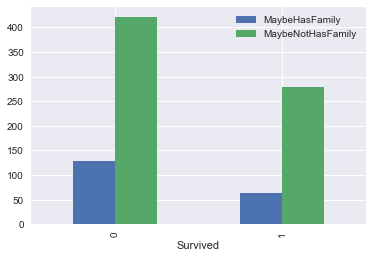

In [241]:
pd.concat([maybe_has_family, maybe_has_not_family], axis=1).plot(kind='bar')

なんか微妙だな・・・？？？  
家族持ち（仮説:　名字が同じ人は家族かも）は生存する確率は低かったかも

思ったけど、FamilySizeが1だったらダメじゃね？
それもフィルタにしないといけないかも

In [255]:
train[train['LastName'].str.contains('Navratil')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,LastName
148,149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.5,0,2,230080,26.0,F2,S,3,Navratil
193,194,1,2,"Navratil, Master. Michel M",male,3.0,1,1,230080,26.0,F2,S,3,Navratil
340,341,1,2,"Navratil, Master. Edmond Roger",male,2.0,1,1,230080,26.0,F2,S,3,Navratil


まだよくわかっていないが、こんな感じ

* LastNameで調べるのは多分正しい
    * FamilySizeと名字が同じ行数がほぼおなじ
    * 違う場合もある。これはノイズになりそうなので、どうにか外さないといけないと思う
    * FamilySizeとLastNameの整合性はあってそうだけど、数が足りない場合がある
        * これはなに？　テストデータに分割しているから、一緒になったらわかるやつかね？

In [4]:
# ここまでのやつをヘルパー関数に追加
train, test = feature_process_helper.family_size_int(train, test)
trian, test = feature_process_helper.add_last_name(train, test)

In [5]:
search_family_train = train.copy()
search_family_test = test.copy()

In [12]:
_test_concat = pd.concat([search_family_train, search_family_test.merge(submission_df, how='inner', on='PassengerId')], axis=0)

In [18]:
_list

['Allison',
 'Andersson',
 'Asplund',
 'Baclini',
 'Boulos',
 'Bourke',
 'Brown',
 'Carter',
 'Collyer',
 'Davies',
 'Elias',
 'Flynn',
 'Ford',
 'Fortune',
 'Goldsmith',
 'Goodwin',
 'Graham',
 'Gustafsson',
 'Hansen',
 'Harper',
 'Harris',
 'Hart',
 'Hickman',
 'Hoyt',
 'Jensen',
 'Johansson',
 'Johnson',
 'Jussila',
 'Kelly',
 'Laroche',
 'Lefebre',
 'Meyer',
 'Moran',
 'Navratil',
 'Newell',
 "O'Brien",
 'Olsen',
 'Palsson',
 'Panula',
 'Rice',
 'Richards',
 'Sage',
 'Skoog',
 'Smith',
 'Taussig',
 'Thayer',
 'Van Impe',
 'Vander Planke',
 'West',
 'Williams']

In [21]:
search_family_train[search_family_train['LastName'].str.contains('Allison')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,LastName
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S,4,Allison
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S,4,Allison
498,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S,4,Allison


In [20]:
_test_concat[_test_concat['LastName'].str.contains('Allison')]

,Age,Cabin,Embarked,FamilySize,Fare,LastName,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
297,2.00,C22 C26,S,4,151.55,Allison,"Allison, Miss. Helen Loraine",2,298,1,female,1,0,113781
305,0.92,C22 C26,S,4,151.55,Allison,"Allison, Master. Hudson Trevor",2,306,1,male,1,1,113781
498,25.00,C22 C26,S,4,151.55,Allison,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",2,499,1,female,1,0,113781
306,30.00,C22 C26,S,4,151.55,Allison,"Allison, Mr. Hudson Joshua Creighton",2,1198,1,male,1,0,113781


名字で紐付けるのは正解っぽいです

In [26]:
# 学習させるためリセット！
# データをそれぞれ読み込む
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/gender_submission.csv')

train = train_df.copy()
test = test_df.copy()

In [27]:
trian, test = feature_process_helper.add_last_name(train, test)
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.family_size_int(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size', 'LastName'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=50,
                             min_samples_split=16,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train.iloc[:, 2:], train.iloc[:, 1])
print("%.4f" % rf.oob_score_)

0.8350


In [31]:
# scikit-learnでは実装されているんだって
# 交差検定をサクッとやるためのモジュールを読み込む
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(rf, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

CV accuracy: 0.832 +/- 0.033


In [35]:
pd.concat((pd.DataFrame(train.iloc[:, 2:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
12,Sex_male,1.358700e-01
25,Name_Title_Mr.,1.151267e-01
13,Sex_female,1.146630e-01
1,Fare,7.114695e-02
2,Name_Len,6.668619e-02
0,Age,6.069747e-02
9,Pclass_3,3.553458e-02
7,FamilySize,3.053070e-02
17,Cabin_Letter_n,2.886756e-02
8,Ticket_Len,2.867102e-02


In [33]:
write_submission._write(model=rf, train=train, test=test, submission_df=submission_df)

 0.79426 ....  
 クソがー！！＼（｀Д´#）ノ

In [85]:
# 流石にLastNameはやり過ぎと思うのでFamilySizeを追加
# 学習させるためリセット！
# データをそれぞれ読み込む
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/gender_submission.csv')

train = train_df.copy()
test = test_df.copy()

In [86]:
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.family_size_int(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Name_Title'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket', 'Cabin', 'SibSp', 'Parch'])

In [87]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=50,
                             min_samples_split=16,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train.iloc[:, 2:], train.iloc[:, 1])
print("%.4f" % rf.oob_score_)

0.8316


In [88]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(rf, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

CV accuracy: 0.840 +/- 0.043


In [89]:
pd.concat((pd.DataFrame(train.iloc[:, 2:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
10,Sex_female,0.137532
9,Sex_male,0.136788
14,Name_Title_Mr.,0.124855
1,Fare,0.112251
2,Name_Len,0.088590
0,Age,0.083733
6,Pclass_3,0.062141
4,FamilySize,0.054231
5,Ticket_Len,0.043362
7,Pclass_1,0.036121


In [90]:
write_submission._write(model=rf, train=train, test=test, submission_df=submission_df)

0.77990  
説明変数を減らしてもダメー

### モデルを複数使ってみる

In [91]:
from sklearn import model_selection, ensemble, svm

In [92]:
rf_clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=0)
et_clf = ensemble.ExtraTreesClassifier(n_estimators=100, random_state=0)
gb_clf = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=0)
ada_clf = ensemble.AdaBoostClassifier(n_estimators=100, random_state=0)
svm_clf = svm.LinearSVC(C=0.1,random_state=0)

In [94]:
e_clf = ensemble.VotingClassifier(estimators=[('rf',rf_clf), ('et',et_clf), ('gbc',gb_clf), ('ada',ada_clf), ('svm',svm_clf)])

In [99]:
# score using cross validation
clf_list = [rf_clf, et_clf, gb_clf, ada_clf, svm_clf, e_clf]
name_list = ['Random Forest', 'Extra Trees', 'Gradient Boosted', 'AdaBoost', 'Support Vector Machine', 'Ensemble']

for clf, name in zip(clf_list,name_list) :
    scores = model_selection.cross_val_score(clf, train.iloc[:, 2:], train.iloc[:, 1], cv=10)
    print("Accuracy: %0.2f +/- %0.2f (%s 95%% CI)" % (scores.mean(), scores.std()*2, name))

Accuracy: 0.84 +/- 0.08 (Random Forest 95% CI)
Accuracy: 0.81 +/- 0.08 (Extra Trees 95% CI)
Accuracy: 0.83 +/- 0.09 (Gradient Boosted 95% CI)
Accuracy: 0.81 +/- 0.07 (AdaBoost 95% CI)
Accuracy: 0.82 +/- 0.07 (Support Vector Machine 95% CI)
Accuracy: 0.83 +/- 0.08 (Ensemble 95% CI)


In [100]:
# fit ensemble classifier
e_clf = e_clf.fit(train.iloc[:, 2:], train.iloc[:, 1])

In [102]:
prediction = e_clf.predict(test.iloc[:, 1:])

In [103]:
from sklearn.cross_validation import cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
cv_scores = cross_val_score(e_clf, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

CV accuracy: 0.831 +/- 0.038


In [104]:
write_submission._write(model=rf, train=train, test=test, submission_df=submission_df)

0.77990

In [109]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(train)

ValueError: Number of features of the model must match the input. Model n_features is 24 and input n_features is 2 

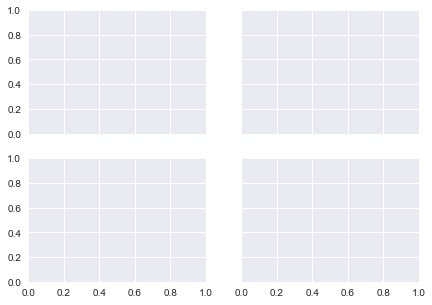

In [115]:
from itertools import product

all_clf = clf_list

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, name_list):
    clf.fit(X_train_std, train.iloc[:, 1])
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='red', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.tight_layout()
# plt.savefig('./figures/voting_panel', bbox_inches='tight', dpi=300)
plt.show()